<a href="https://colab.research.google.com/github/akkirajubhavana/SMAI_2024_ASSIGNMENTS/blob/main/SMAI_A1_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [19]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [22]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import gdown
gdown.download("https://drive.google.com/file/d/1sXrLZgvH238JN5yJYTMQh50BjUmWwan_/view?usp=drive_link", "/content/coco_captions.npy", quiet=False)
gdown.download("https://drive.google.com/file/d/1RQKValuA-oGEx7s7OyGdtvz_L3tHUKSW/view?usp=drive_link", "/content/coco_imgs.npy", quiet=False)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:44: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1sXrLZgvH238JN5yJYTMQh50BjUmWwan_
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1sXrLZgvH238JN5yJYTMQh50BjUmWwan_/view?usp=drive_link
To: /content/coco_captions.npy
8.22kB [00:00, 11.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:44: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1RQKValuA-oGEx7s7OyGdtvz_L3tHUKSW
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1RQKValuA-oGEx7s7OyGdtvz_L3tHUKSW/view?usp=drive_link
To: /content/coco_imgs.npy
8.22kB [00:00, 8.40MB/s]


'/content/coco_imgs.npy'

In [20]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW

but Gdown can't. Please check connections and permissions.


In [23]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

--2024-02-01 16:36:12--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.234.177, 52.216.145.51, 52.217.133.137, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.234.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip.1’

val2014.zip.1       100%[===================>]   6.19G  45.0MB/s    in 2m 46s  

2024-02-01 16:38:58 (38.3 MB/s) - ‘val2014.zip.1’ saved [6645013297/6645013297]

Archive:  /content/val2014.zip
replace val2014/COCO_val2014_000000324670.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace val2014/COCO_val2014_000000464263.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N A
A
A
n
--2024-02-01 16:39:59--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.40.153, 52.217.204.41, 54.231.131.73, ...
Connecting to images.

In [40]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(42)

In [25]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [ ]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [ ]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [28]:
cap_path = '/content/drive/MyDrive/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [29]:
img_path = '/content/drive/MyDrive/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [30]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [93]:
def cosine_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity


In [94]:
# Assuming you have your image_embeddings, caption_embeddings, and captions_np defined
x_train, x_test, y_train, y_test, y_captions_train, y_captions_test = train_test_split(
    image_embeddings, caption_embeddings, captions_np, test_size=0.2, random_state=42
)


In [95]:
index = faiss.IndexFlatL2(512)
index.add(x_train)
print(index.is_trained)

True


In [96]:
def query_expansion_with_indices(x_test_instance, x_train, caption_embeddings, index, k):
    D, I = index.search(np.reshape(x_test_instance, (-1, 512)), k)
    query_vector = np.zeros(512, dtype=np.float32)
    Z = np.sum(D[0])

    for i in range(len(D)):
        similarity_score = 1 - (D[0][i] / Z)
        nearest_neighbor_indices = I[0][i]
        nearest_neighbor_embeddings = caption_embeddings[nearest_neighbor_indices]

        query_vector += np.sum(similarity_score.reshape(-1, 1) * nearest_neighbor_embeddings, axis=0)

    query_vector = (1 / (k * 5)) * query_vector
    return query_vector, nearest_neighbor_indices


In [97]:
def re_rank_candidates_with_indices(candidates, query_vector, caption_embeddings, I, y_captions_train, nearest_neighbor_indices):
    all_captions_instances = np.reshape(candidates, (-1, 512))
    similarities = np.array([cosine_similarity(query_vector, instance) for instance in all_captions_instances])
    sorted_idx = np.argsort(similarities)
    all_captions_text = y_captions_train[I].flatten()

    # Return both the top-ranked caption and its similarity score
    top_ranked_caption = all_captions_text[sorted_idx[0]]
    top_similarity_score = similarities[sorted_idx[0]]

    return top_ranked_caption, top_similarity_score

In [98]:
def predict_with_similarity(x_test, x_train, caption_embeddings, index, k, y_captions_train, y_captions_test):
    predictions = []
    query_captions = []  # To store captions of the queries
    top_ranked_captions = []  # To store captions of the top-ranked candidates

    for i, instance in enumerate(x_test):
        query_vector, nearest_neighbor_indices = query_expansion_with_indices(instance, x_train, caption_embeddings, index, k)
        D, I = index.search(np.reshape(instance, (-1, 512)), k)
        candidates = caption_embeddings[I[0]]

        # Use re_rank_candidates_with_indices to get the top-ranked caption and its similarity score
        top_caption, top_similarity = re_rank_candidates_with_indices(candidates, query_vector, caption_embeddings, I, y_captions_train, nearest_neighbor_indices)
        predictions.append((top_caption, top_similarity))

        # Store captions of the query and top-ranked candidate
        query_captions.append(y_captions_test[i])
        top_ranked_captions.append(top_caption)

    return predictions, query_captions, top_ranked_captions

In [99]:
k= 5

predictions, query_captions, top_ranked_captions=predict_with_similarity(x_test, x_train, caption_embeddings, index, k, y_captions_train, y_captions_test)

In [100]:
bleu_accuracy_top_vs_query = accuracy(top_ranked_captions, query_captions)
print(f"BLEU Accuracy (Top vs. Query): {bleu_accuracy_top_vs_query * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Accuracy (Top vs. Query): 54.09%


In [108]:
k_values = [3, 5, 7,10,20]  # Try different values of k
accuracy_value =[]
for k_value in k_values:
    predictions, query_captions, top_ranked_captions=predict_with_similarity(x_test, x_train, caption_embeddings, index, k_value, y_captions_train, y_captions_test)

    bleu_accuracy = accuracy(top_ranked_captions, query_captions)
    accuracy_value.append(bleu_accuracy)
    print(f"For k={k_value}, BLEU Accuracy: {bleu_accuracy}")


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


For k=3, BLEU Accuracy: 0.44135877013906066
For k=5, BLEU Accuracy: 0.44135877013906066
For k=7, BLEU Accuracy: 0.44135877013906066
For k=10, BLEU Accuracy: 0.44135877013906066
For k=20, BLEU Accuracy: 0.44135877013906066


In [103]:
import time
index_factory_strings = ["PCA32,Flat", "PCA64,Flat", "PCA80,Flat", "HNSW32", "OPQ16_64,IMI2x8,PQ8+16"]
k = 10

for index_factory_string in index_factory_strings:
    start_time = time.time()
    index = faiss.index_factory(512, index_factory_string)
    index.train(x_train)

    predictions, query_captions, top_ranked_captions = predict_with_similarity(
        x_test, x_train, caption_embeddings, index, k, y_captions_train, y_captions_test
    )

    end_time = time.time()
    accuracy_value = accuracy(top_ranked_captions, query_captions)

    print("Execution with", index_factory_string, "is", end_time - start_time, "seconds and accuracy is", accuracy_value)


Execution with PCA32,Flat is 5.6892409324646 seconds and accuracy is 0.44135877013906066
Execution with PCA64,Flat is 6.016871452331543 seconds and accuracy is 0.44135877013906066
Execution with PCA80,Flat is 7.721092700958252 seconds and accuracy is 0.44135877013906066
Execution with HNSW32 is 7.554689884185791 seconds and accuracy is 0.44135877013906066
Execution with OPQ16_64,IMI2x8,PQ8+16 is 45.56348967552185 seconds and accuracy is 0.44135877013906066


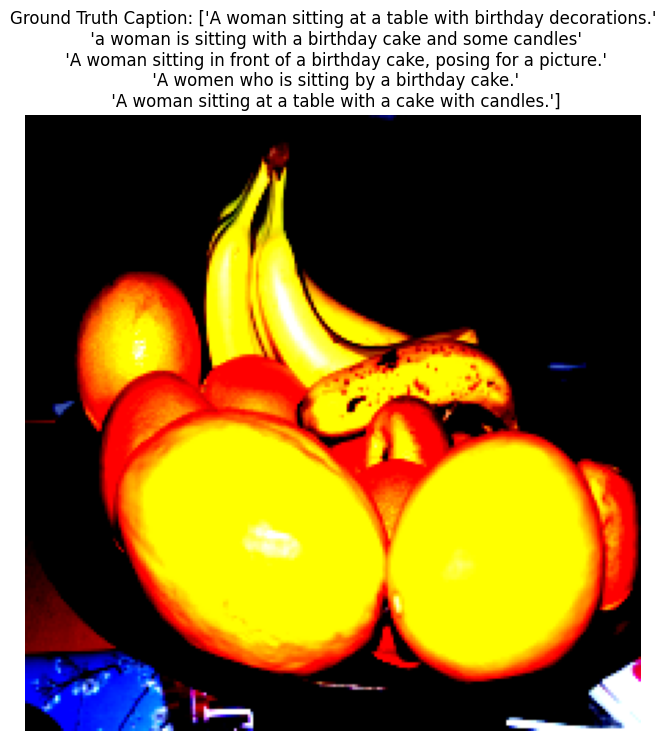

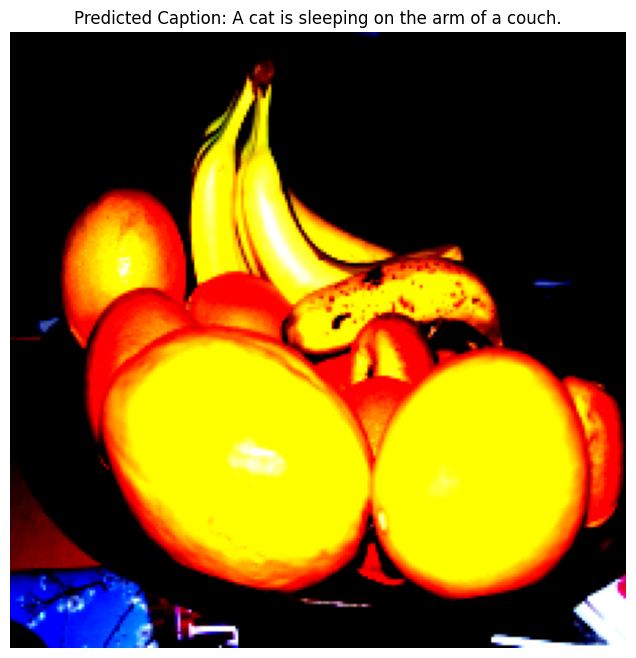

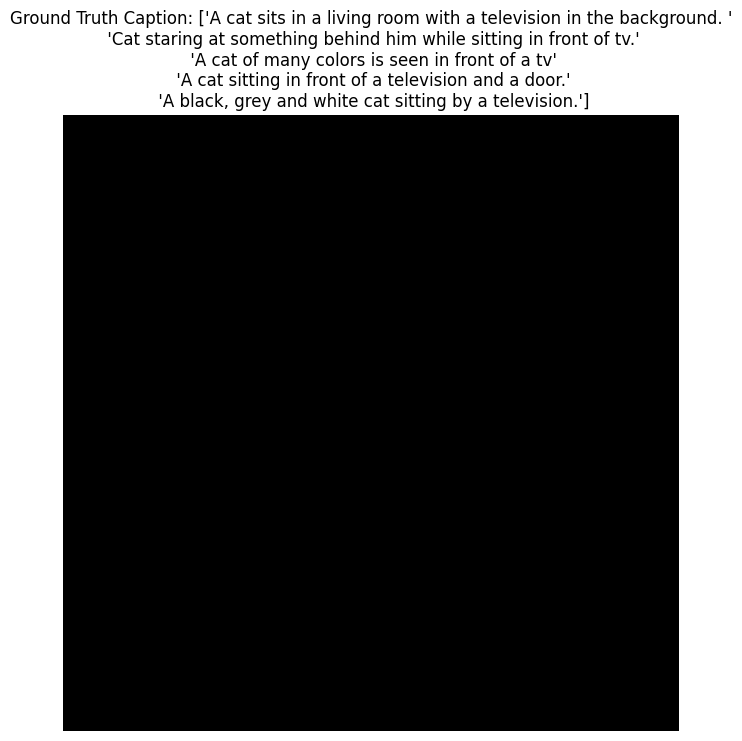

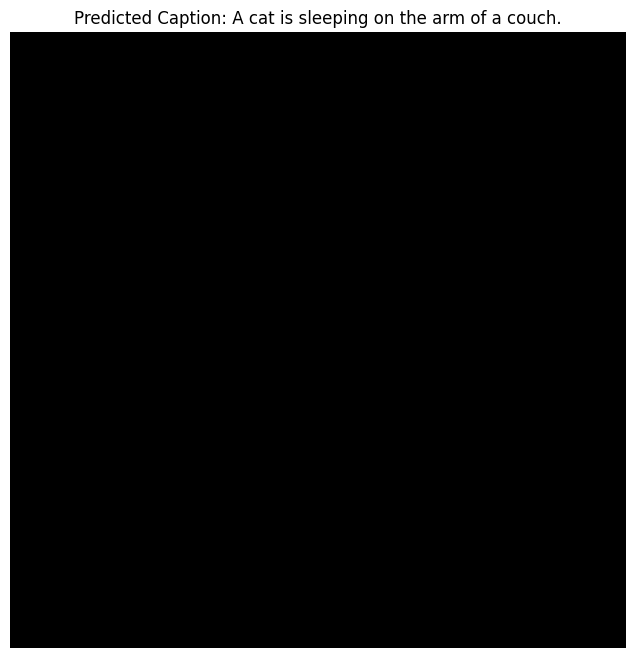

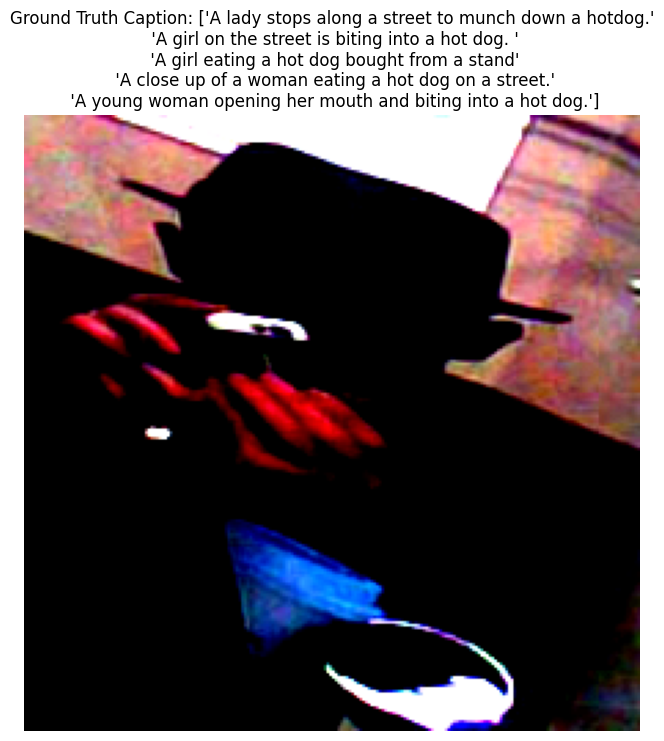

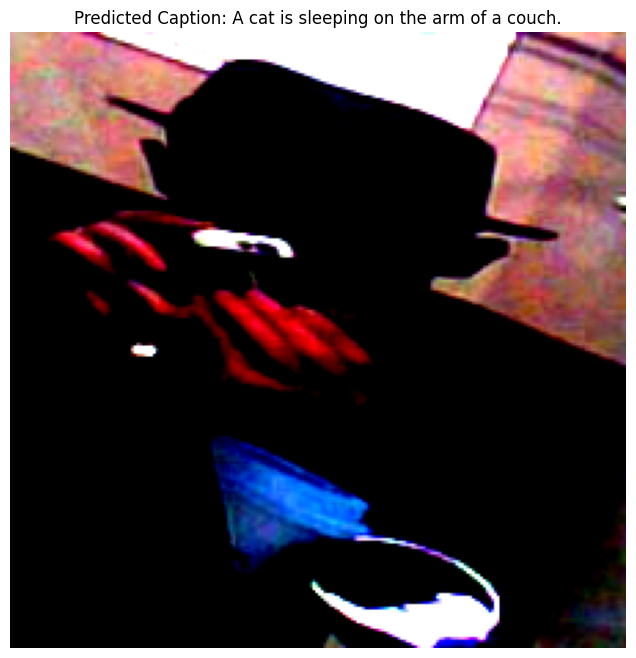

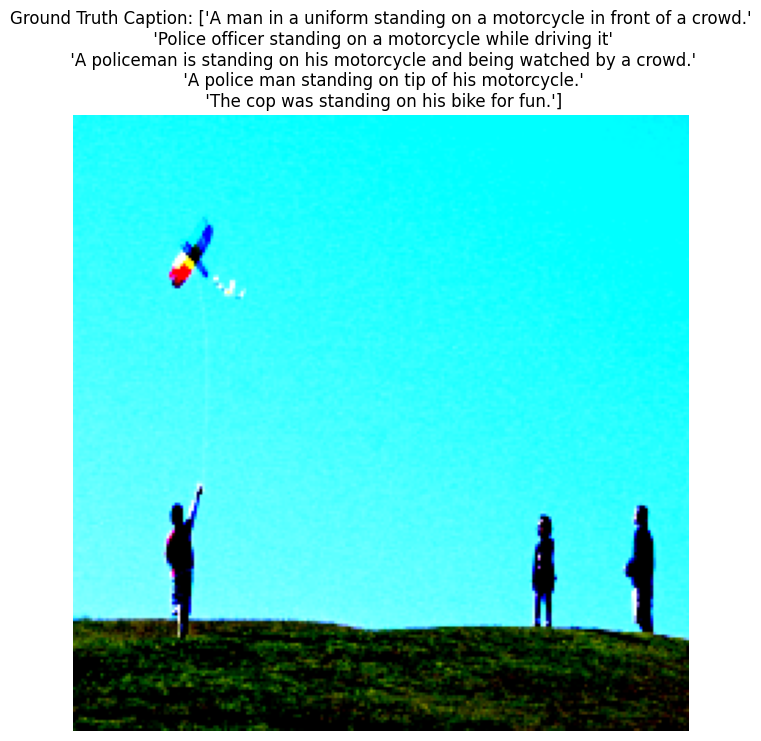

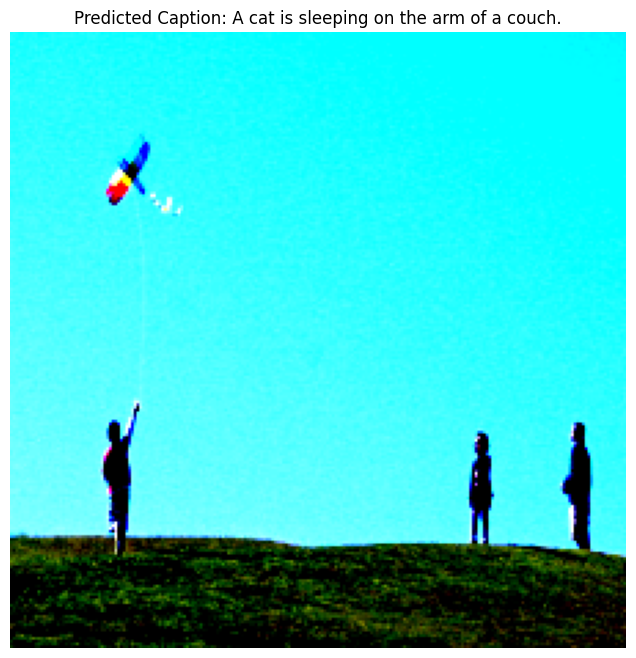

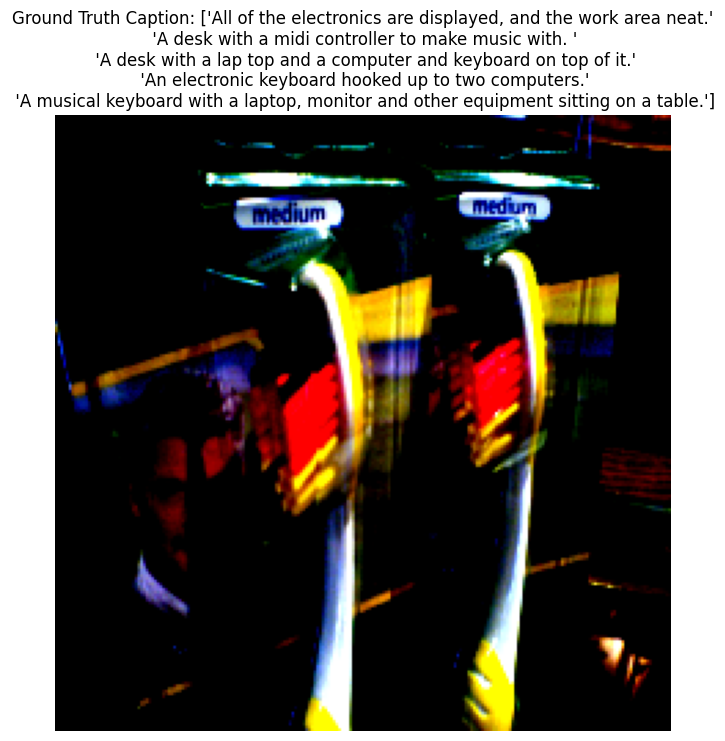

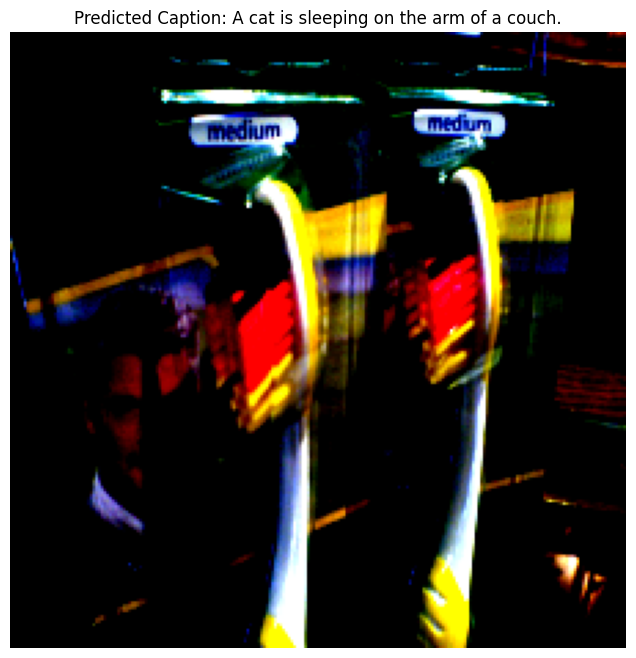

In [117]:
import matplotlib.pyplot as plt
import random

# Choose five random indices from the test set
random_indices = random.sample(range(len(x_test)), 5)

for i, idx in enumerate(random_indices):
    # Get the image, ground truth caption, and predicted caption
    image, _ = coco_dset[idx]
    ground_truth_caption = query_captions[i]
    predicted_caption= top_ranked_captions[i]

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

    # Display the ground truth caption
    plt.title(f'Ground Truth Caption: {ground_truth_caption}', fontsize=12)
    plt.show()

    # Display the predicted caption
    plt.figure(figsize=(8, 8))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Predicted Caption: {predicted_caption}', fontsize=12)
    plt.show()


True


**Observation**
* As k value increases, accuracy decreased
